# Hierarchical Clustering (raw points)

In [1]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import ast
import os
import sys

In [2]:
tqdm.pandas()

/usr/local/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
actions_df_path = Path("../processed/actions_day_1.csv")

In [4]:
actions_df = pd.read_csv(actions_df_path)

In [5]:
def get_group_size(row):
    return max(ast.literal_eval(row))

gs = actions_df["groupSize"].progress_apply(get_group_size)

100%|██████████| 558860/558860 [00:09<00:00, 56264.06it/s]


In [6]:
duration = list(actions_df["end_time"] - actions_df["time"])

In [7]:
points = np.array(list(zip(gs, duration)), dtype=np.int64)

In [8]:
scaler = StandardScaler()
scaler.fit(points)

StandardScaler()

In [9]:
points_scaled = scaler.transform(points)

In [10]:
import matplotlib.pyplot as plt

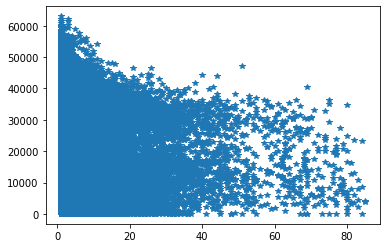

In [81]:

plt.plot(points[:, 0], points[:, 1], '*')

plt.show()

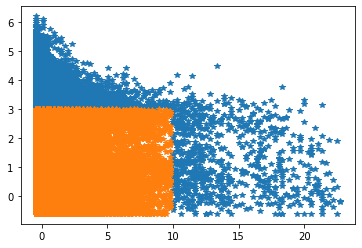

In [21]:
mask = (points_scaled[:, 0] > 10) | (points_scaled[:, 1] > 3)

for i in range(2):
    if i == 0:
        plt.plot(points_scaled[mask, 0], points_scaled[mask, 1], '*')
    else:
        plt.plot(points_scaled[~mask, 0], points_scaled[~mask, 1], '*')

plt.show()

In [22]:
def exponential_decay(const, rate, x):
    return const * np.e**(rate*x)

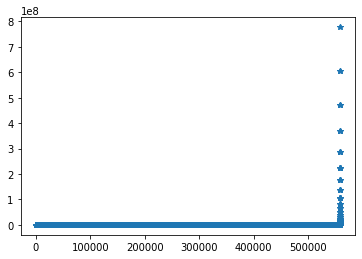

In [23]:
plt.plot(list(range(len(gs))), sorted([exponential_decay(1, 0.9, y) for y in points_scaled[:, 0]]), '*')
plt.show()

In [24]:
points_1 = np.array(list(zip([exponential_decay(1, 0.9, y) for y in points_scaled[:, 0]], [exponential_decay(1, 0.9, y) for y in points_scaled[:, 1]])))

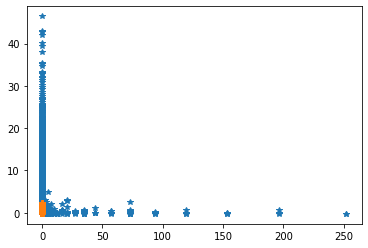

In [26]:
scaler_2 = StandardScaler()
points_1_scaled = scaler_2.fit_transform(points_1)

for i in range(2):
    if i == 0:
        plt.plot(points_1_scaled[mask, 0], points_1_scaled[mask, 1], '*')
    else:
        plt.plot(points_1_scaled[~mask, 0], points_1_scaled[~mask, 1], '*')

plt.show()

# Read the ground truth

In [27]:
file_path = Path("../simulation_data/v4/infectionEvents.txt")

In [28]:
infectionEvents = pd.read_csv(file_path, sep="\t")

In [29]:
infectionEvents

,time,infector,infected,infectionType,date,groupSize,facility
0,284037.0,7861927,7874412,home_home,2020-01-26,8,home_3512319
1,284144.0,1099944,1099946,home_home,2020-01-26,3,home_584851
2,286922.0,7861927,8721391,home_home,2020-01-26,7,home_3512319
3,287593.0,1099944,1099943,home_home,2020-01-26,2,home_584851
4,289080.0,1099944,9489442,pt,2020-01-26,5,PT!100110008:8!120204114-1_201503!120204106-1_...
...,...,...,...,...,...,...,...
28243,1900799.0,11716186,11643434,leisure_leisure,2020-02-13,2,sec_228396
28244,1900799.0,459387,10084356,leisure_leisure,2020-02-13,2,sec_316322
28245,1900799.0,10274352,8231283,work_work,2020-02-13,2,work_374068
28246,1900799.0,6095093,3862422,home_home,2020-02-13,4,home_1824534


In [31]:
actions_df

,Unnamed: 0,person,time,container,end_time,groupSize,contactPeople,almostContactPeople
0,0,21,122385.0,sec_490124,124837.0,[1],[],NaN
1,1,21,125232.0,sec_425380,126637.0,[1],[],NaN
2,2,21,127214.0,home_5,139237.0,[1],[],NaN
3,3,21,139380.0,PT!100110007:7!120200199-1_202458!120062097-1_...,139860.0,[2],[9437416],NaN
4,4,21,140160.0,PT!100100180:180!120178341-1_235191!120178340-...,141059.0,[1],[],NaN
...,...,...,...,...,...,...,...,...
558855,558855,11757462,148816.0,sec_422532,153103.0,[1],[],NaN
558856,558856,11757462,154860.0,PT!059440045:45!120582766-1_81480!120582367-1_...,155700.0,[2],[11477709],NaN
558857,558857,11757462,155999.0,sec_379487,155999.0,[1],[],NaN
558858,558858,11757462,156300.0,PT!059440045:45!120582766-1_81480!120582399-1_...,156600.0,[2],[6987759],NaN


In [45]:
gold_labels = []

for action_row_id, action_row in tqdm(actions_df.iterrows()):
    temp = False
            
    if np.sum(np.array(list(infectionEvents["infected"] == action_row["person"]), dtype=np.bool) & np.array(list(infectionEvents["facility"] == action_row["container"]), dtype=np.bool)):
        temp = True
    
    gold_labels.append(temp)

558860it [1:50:51, 84.03it/s]


In [48]:
gold_labels = np.array(gold_labels)

In [75]:
mask = (points_scaled[:, 0] > 11) | (points_scaled[:, 1] > 3)

In [72]:
sum(mask == gold_labels) / len(gold_labels)

0.9301864509895144

In [73]:
from sklearn.metrics import f1_score

In [76]:
f1_score(gold_labels, mask)

0.13387279638974722

In [82]:
1

1

In [89]:
a = 1
def func1():
    func()

def func():
    nonlocal a
    print(a)

func1()

SyntaxError: no binding for nonlocal 'a' found (<ipython-input-89-e775702c0621>, line 6)